In [31]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import statsmodels.graphics.tsaplots as sm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from statsmodels.tsa.arima_model import ARIMA
import  warnings
from matplotlib.pylab import rcParams
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
import random
from random import randint
from tqdm import tqdm
import collections

warnings.simplefilter('ignore')
rcParams['figure.figsize'] = 15, 6

In [3]:
data = np.loadtxt('lynx_.txt')

In [4]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return serie

def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()
    
def erro_function(data, modelo):
    return data - modelo.predict()
    
def train_valid_test_split(serie, num_lags, tr_vd_ts_percents = [80, 20], print_shapes = False):
    len_serie = len(serie)
    X = np.zeros((len_serie, num_lags))
    y = np.zeros((len_serie,1))
    for i in np.arange(0, len_serie):
        if i-num_lags>=0:
            X[i,:] = serie[i-num_lags:i]
            y[i] = serie[i]
        else:
            X[i,0:i] = serie[0:i]
    
    len_train = np.floor(len_serie*tr_vd_ts_percents[0]/100).astype('int')
    len_test = np.ceil(len_serie*tr_vd_ts_percents[1]/100).astype('int')
    
    X_train = X[0:len_train]
    y_train = y[0:len_train]
    X_test = X[len_train:len_train+len_test]
    y_test = y[len_train:len_train+len_test]
       
    return X_train, y_train, X_test, y_test

def train_valid_test_split_prev(serie, num_lags, tr_vd_ts_percents = [80, 20], print_shapes = False):
    len_serie = len(serie)
    X = np.zeros((len_serie, num_lags))
    y = np.zeros((len_serie,1))
    for i in np.arange(0, len_serie-(num_lags+1)):
        X[i,:] = serie[i+1:i+num_lags+1]
        y[i] = serie[i]
    
    len_train = np.floor(len_serie*tr_vd_ts_percents[0]/100).astype('int')
    len_test = np.ceil(len_serie*tr_vd_ts_percents[1]/100).astype('int')
    
    X_train = X[0:len_train]
    y_train = serie[0:len_train]
    X_test = X[len_train:len_train+len_test]
    y_test = y[len_train:len_train+len_test]
    
    return X_train, y_train, X_test, y_test

0.09066070895201199


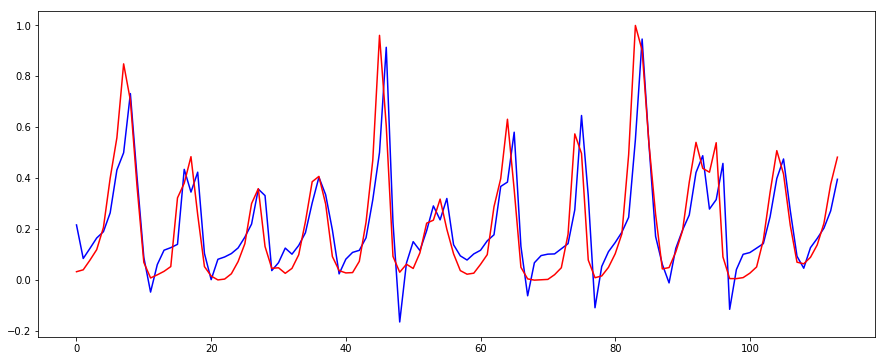

In [45]:
def arima_function(data, lag=17, p=12, q=0, d=0):
    threshold = int(len(data)*0.8)
    data_train_arima = data[0:threshold]
    data_test_arima = data[threshold:]

    #modelo_arima = ARIMA(data, order=(p,d,q)).fit(disp=0)
    model = ARIMA(data_train_arima, order=(p,q,d))
    modelo_arima = model.fit()
    #modelo_arima = modelo_arima.fit(disp=0)
#     historico = [x for x in data_train_arima]
#     previsoes = []
#     for i in range(len(data_test_arima)):
#         modelo_arima = ARIMA(historico, order=(p,d,q)).fit()
#         prev = modelo_arima.forecast()[0]
#         previsoes.append(prev)
#         obs = data_test_arima[i]
#         historico.append(obs)
    return modelo_arima, data_train_arima, data_test_arima
modelo, data_train_arima, data_test_arima = arima_function(normalizar_serie(data), lag=19, p=12, q=0, d=0)
plt.plot(modelo_arima.predict(), 'b')
plt.plot(normalizar_serie(data), 'r')
print(mae(modelo_arima.predict()[-len(data_test_arima):], data_test_arima))

In [6]:
def inicializacao_populacao_mlp(size_mlp):
    activation = ['identity','logistic', 'tanh', 'relu']
    solver = ['lbfgs','sgd', 'adam']
    pop =  np.array([[random.choice(activation), random.choice(solver), randint(2,100), randint(2,100)]])
    for i in range(0, size_mlp-1):
        pop = np.append(pop, [[random.choice(activation), random.choice(solver), randint(2,100), randint(2,100)]], axis=0)
    return pop

def cruzamento_mlp(pai_1, pai_2):
    child = [pai_1[0], pai_2[1], pai_1[2], pai_2[3]]    
    return child

def mutacao_mlp(child, prob_mut):
    child_ = np.copy(child)
    for c in range(0, len(child_)):
        if np.random.rand() >= prob_mut:
            k = randint(2,3)
            child_[c,k] = int(child_[c,k]) + randint(1, 4)
    return child_


def function_fitness_mlp(pop, X_train, y_train, X_test, y_test, size_mlp): 
    fitness = {}
    j = 0
    for w in pop:
        clf = MLPRegressor(activation=w[0], solver=w[1], alpha=1e-5, hidden_layer_sizes=(int(w[2]), int(w[3])), random_state=1)
        clf.fit(X_train, y_train)
        try:
            fitness[mae(clf.predict(X_test), y_test)] = clf
        except:
            pass
    return fitness#collections.OrderedDict(sorted(fitness.items()))


def ag_mlp(X_train, y_train, X_test, y_test, num_epochs = 10, size_mlp=10, prob_mut=0.8):
    pop = inicializacao_populacao_mlp(size_mlp)
    fitness = function_fitness_mlp(pop,  X_train, y_train, X_test, y_test, size_mlp)
    pop_fitness = np.array(list(zip(pop, fitness)))
    pop_fitness_sort = pop_fitness[pop_fitness[:,1].argsort()]
    
    for j in range(0, num_epochs):#for j in range(0, 1):#num_epochs):
        #seleciona os pais
        parent_1 = pop_fitness_sort[0:int(size_mlp/2)][:,0]
        parent_2 = pop_fitness_sort[int(size_mlp/2)::][:,0]
        child_1 = [cruzamento_mlp(parent_1[i], parent_2[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = [cruzamento_mlp(parent_2[i], parent_1[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        child_2 = mutacao_mlp(child_2, prob_mut)
        
        #calcula o fitness dos filhos para escolher quem vai passar pra próxima geração
        fitness_child_1 = function_fitness_mlp(child_1,X_train, y_train, X_test, y_test, size_mlp)
        fitness_child_2 = function_fitness_mlp(child_2, X_train, y_train, X_test, y_test, size_mlp)
        fitness.update(fitness_child_1)
        fitness.update(fitness_child_2)    
        fitness_child_1 = np.array(list(zip(child_1, fitness_child_1)))
        fitness_child_2 = np.array(list(zip(child_2, fitness_child_2)))
        #print (itness_child_2.shape, fitness_child_1.shape, pop_fitness.shape)
        #seleciona individuos da proxima geração
        
        pop_all = np.concatenate((fitness_child_1, fitness_child_2, pop_fitness_sort), axis=0)
        
        pop_all_sort = pop_all[pop_all[:,1].argsort()]
        best_individual = fitness[pop_all_sort[0,1]]
        pop_fitness_sort = pop_all_sort[0:size_mlp]
        
        
    return best_individual


In [8]:
def inicializacao_populacao(size_pop):
    pop =  [[]]*size_pop
    pop = [[randint(1,17),randint(1,17),randint(1,17),randint(1,17),randint(1,17)]for i in range(0, size_pop)]
    return pop

def cruzamento(pai_1, pai_2):
    child = [pai_1[0], pai_2[1], pai_1[2], pai_2[3], pai_1[4]]
    return child

def mutacao(child, prob_mut):
    child_ = np.copy(child)
    for c in range(0, len(child_)):
        if np.random.rand() > prob_mut:
            k = randint(0,1)
            child_[c][k] = int(child_[c][k]) + randint(1, 5)
    return child_

def function_fitness(pop, modelo_arima, data, data_train, data_test, erro, size_pop, prob_mut, num_epoch): 
    fitness_modelo = {}#[[]]*size_pop
    fitness_erro = {}
#     melhor_modelo = [[]]*size_pop
#     melhor_modelo_erro = [[]]*size_pop
    j = 0
    for ind in pop:
        #erro estimado
        erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_valid_test_split(erro, ind[0], [80, 20])
        best_erro = ag_mlp(erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida, num_epochs = num_epoch, size_mlp = size_pop, prob_mut=prob_mut)
        #erro_estimado = np.concatenate([best_erro.predict(erro_train_entrada), best_erro.predict(erro_test_entrada)])
        erro_estimado = np.concatenate([erro[0:len(erro_train_entrada)], best_erro.predict(erro_test_entrada)])
    
        #y estimado
        X_ass_1_train_in, X_ass_1_train_out, X_ass_1_test_in, X_ass_1_test_out = train_valid_test_split(modelo_arima.predict(), ind[1], [80, 20])
        X_ass_2_train_in, X_ass_2_train_out, X_ass_2_test_in, X_ass_2_test_out = train_valid_test_split(erro_estimado, ind[2], [80, 20])
        X_ass_3_train_in, X_ass_3_train_out, X_ass_3_test_in, X_ass_3_test_out = train_valid_test_split_prev(modelo_arima.predict(), ind[3], [80, 20])
        X_ass_4_train_in, X_ass_4_train_out, X_ass_4_test_in, X_ass_4_test_out = train_valid_test_split_prev(erro_estimado, ind[4], [80, 20])
        X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in, X_ass_3_train_in, X_ass_4_train_in), axis=1)
        X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in, X_ass_3_test_in, X_ass_4_test_in), axis=1) 

        best_ass = ag_mlp(X_in_train, data_train, X_in_test, data_test, num_epochs = num_epoch, size_mlp = size_pop, prob_mut=prob_mut)      
        try: 
            fitness_modelo[mae(best_ass.predict(X_in_test), data_test)] = best_ass
            fitness_erro[mae(best_ass.predict(X_in_test), data_test)] = best_erro
#             fitness[j] = mae(best_ass.predict(X_in_test), data_test)
#             melhor_modelo[j] = best_ass
#             melhor_modelo_erro[j] = best_erro
        except:
            pass
        
        #j = j+1
    return fitness_modelo, fitness_erro#melhor_modelo, melhor_modelo_erro

def ag_main(data, num_epoch = 10, size_pop = 10, prob_mut=0.7):
    evolution = []
    modelo_arima, data_train, data_test  = arima_function(data, lag=20)
    erro = erro_function(data, modelo_arima)
    pop = inicializacao_populacao(size_pop)
    melhor_modelo, melhor_modelo_erro = function_fitness(pop, modelo_arima, data, data_train, data_test, erro, size_pop, prob_mut, num_epoch)
    pop_fitness = np.array(list(zip(pop, melhor_modelo)))
    pop_fitness_sort = pop_fitness[pop_fitness[:,1].argsort()]
    
    #seleciona os pais
    for j in tqdm(range(0,num_epoch)):
        #calcula o fitness da população
        parent_1 = pop_fitness_sort[0:int(size_pop/2)][:,0]
        parent_2 = pop_fitness_sort[int(size_pop/2)::][:,0]
#         #cruzamento
        child_1 = [cruzamento(parent_1[i], parent_2[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
        #child_1 = np.array(list(map(list, child_1)))
        child_2 = [cruzamento(parent_2[i], parent_1[i]) for i in range(0, np.min([len(parent_2), len(parent_1)]))]
    
#         child_2 = np.array(list(map(list, child_2)))

        child_2 = mutacao(child_2, prob_mut)
    
        #calcula o fitness dos filhos para escolher quem vai passar pra próxima geração
        melhor_modelo_child_1, melhor_modelo_erro_child_1  = function_fitness(child_1,modelo_arima, data, data_train, data_test, erro, size_pop, prob_mut, num_epoch)
        melhor_modelo_child_2, melhor_modelo_erro_child_2  = function_fitness(child_2, modelo_arima, data,data_train, data_test, erro, size_pop, prob_mut, num_epoch)
        melhor_modelo.update(melhor_modelo_child_1)
        melhor_modelo.update(melhor_modelo_child_2)
        melhor_modelo_erro.update(melhor_modelo_erro_child_1)
        melhor_modelo_erro.update(melhor_modelo_erro_child_2)
        fitness_child_1 = np.array(list(zip(child_1, melhor_modelo_child_1)))
        fitness_child_2 = np.array(list(zip(child_2, melhor_modelo_child_2)))
#         #seleciona individuos da proxima geração
        pop_all = np.concatenate((fitness_child_1, fitness_child_2, pop_fitness_sort), axis=0)
        pop_all_sort = pop_all[pop_all[:,1].argsort()]
#         
        pop_fitness_sort = pop_all_sort[0:size_pop]
        modelo_ass = melhor_modelo[pop_all_sort[0,1]]
        modelo_erro = melhor_modelo_erro[pop_all_sort[0,1]]
        evolution.append(pop_all_sort[0,1])
    return  modelo_ass, modelo_erro, pop_all_sort[0], evolution

In [9]:
# modelo_arima, data_train, data_test  = arima_function(data, lag=20)
# erro = erro_function(data, modelo_arima)
# pop = inicializacao_populacao(6)
# melhor_modelo, melhor_modelo_erro = function_fitness(pop, modelo_arima, data, data_train, data_test, erro, 6, 0.8, 6)

modelo_ass, modelo_erro, fitness, evolution = ag_main(normalizar_serie(data), num_epoch = 15, size_pop = 15, prob_mut=0.7)

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:11:26<00:00, 275.97s/it]


In [15]:
fitness

array([list([15, 4, 10, 7, 4]), 0.05527540617851967], dtype=object)

True
mae predição:
0.06769707394767174
mae arima: 
0.09066070895201199
ganho:
0.7467079700811161


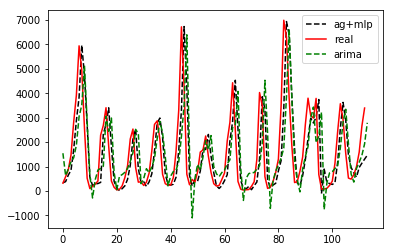

In [20]:
ind = fitness[0]
modelo_arima, data_train, data_test  = arima_function(normalizar_serie(data), lag=20)
erro = erro_function(normalizar_serie(data), modelo_arima)

erro_train_entrada, erro_train_saida, erro_test_entrada, erro_test_saida = train_valid_test_split(erro, ind[0], [80, 20])
erro_estimado = np.concatenate([erro[0:len(erro_train_entrada)], modelo_erro.predict(erro_test_entrada)])


X_ass_1_train_in, X_ass_1_train_out, X_ass_1_test_in, X_ass_1_test_out = train_valid_test_split(modelo_arima.predict(), ind[1], [80, 20])
X_ass_2_train_in, X_ass_2_train_out, X_ass_2_test_in, X_ass_2_test_out = train_valid_test_split(erro_estimado, ind[2], [80, 20])
X_ass_3_train_in, X_ass_3_train_out, X_ass_3_test_in, X_ass_3_test_out = train_valid_test_split_prev(modelo_arima.predict(), ind[3], [80, 20])
X_ass_4_train_in, X_ass_4_train_out, X_ass_4_test_in, X_ass_4_test_out = train_valid_test_split_prev(erro_estimado, ind[4], [80, 20])

X_in_train = np.concatenate((X_ass_1_train_in, X_ass_2_train_in, X_ass_3_train_in, X_ass_4_train_in), axis=1)
X_in_test = np.concatenate((X_ass_1_test_in, X_ass_2_test_in, X_ass_3_test_in, X_ass_4_test_in), axis=1) 

y_estimado = np.concatenate([modelo_ass.predict(X_in_train), modelo_ass.predict(X_in_test)])

print (mae(modelo_ass.predict(X_in_test), data_test) ==  fitness[1])
print ('mae predição:')
print (mae(modelo_ass.predict(X_in_test), data_test, data_test))
print ('mae arima: ')
print(mae(modelo_arima.predict()[-len(data_test):], data_test))
print ('ganho:')
print (mae(modelo_ass.predict(X_in_test), data_test, data_test)/mae(modelo_arima.predict()[-len(data_test):], data_test))
plt.plot(desnormalizar(y_estimado, data), 'k--', label='ag+mlp')
plt.plot(data[1:] , 'r', label='real')
plt.plot(desnormalizar(modelo_arima.predict(), data), 'g--', label = 'arima')
plt.legend()

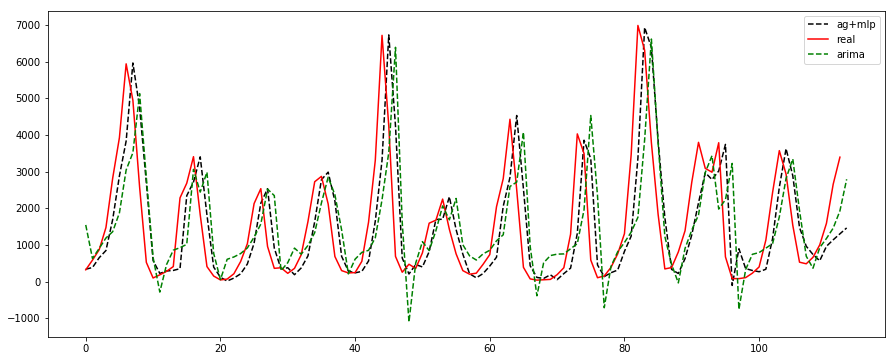

In [49]:
plt.plot(desnormalizar(y_estimado, data), 'k--', label='ag+mlp')
plt.plot(data[1:] , 'r', label='real')
plt.plot(desnormalizar(modelo_arima.predict(), data), 'g--', label = 'arima')
plt.legend()

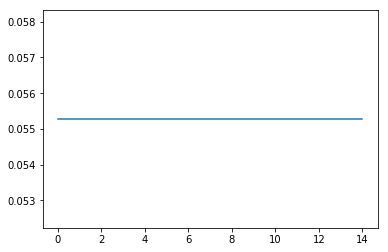

In [28]:
plt.plot(evolution)

In [48]:
print ('mse predição:')
print (mse(modelo_ass.predict(X_in_test), data_test ))
print ('mse arima: ')
print(mse(modelo_arima.predict()[-len(data_test):], data_test))
print ('ganho:')
print (mae(desnormalizar(modelo_ass.predict(X_in_test), data[-len(data_test):]), data[-len(data_test):] )/mae(desnormalizar(modelo_arima.predict()[-len(data_test):], data[-len(data_test):]), data[-len(data_test):]))

mse predição:
0.007690076875376474
mse arima: 
0.01412557186964029
ganho:
0.9451711113207265


114

In [ ]:
mae(y_estimado, data)